![casing_sketch](./figures/casing_sketch.png)

# imports

If you run into an import error, try opening a command line and running:
```
pip install -r requirements.txt
```

then restart the Kernel (keyboard shortcut: `esc00` or from the menu Kernel --> restart

In [1]:
# core python
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import time
from scipy.constants import inch, mu_0

# SimPEG related
import discretize
from pymatsolver import Pardiso
from SimPEG.EM import FDEM
from SimPEG import Maps, versions
from SimPEG.Survey import Data

# utilities related to casing
import casingSimulations as casingSim

%matplotlib inline

# model parameters

In [2]:
# conductivities of the casing
sigma_inside = 1
sigma_casing = 6.25e5

# conductivity of the background
sigma_background_vertical = 1/2700
sigma_background_horizontal = 1/300

# relative permeability of the casing
mur_casing = 128

# casing_geometry (in m)
casing_a = 5.9375 * inch
casing_b = 6.6875 * inch

# z-extent of the casing
casing_z = 1000 * np.r_[-1, 1]

# survey parameters

In [3]:
freq = 8. 
src_z = 0

# design a mesh

this is an object that keeps track of hand parameters with respect to geometry of the
model and has utilities that can assign the model to a mesh


In [4]:
model_parameters = casingSim.model.CasingInWholespace(
    casing_d=(casing_a+casing_b),
    casing_t=casing_b - casing_a,
    casing_l=casing_z[1]-casing_z[0],
    casing_top=casing_z[1], 
    mur_casing=mur_casing,
    sigma_back=sigma_background_horizontal,
    sigma_casing=sigma_casing,
    sigma_inside=sigma_inside,
    src_a=np.r_[0., 0., src_z],
    src_b=np.r_[0., 0., src_z],
    freqs=[freq]
)

This is a utility for generating sensible meshes for the casing simulation. In the radial direction, there are two regions of uniform cell spacing. The smallest is right around the casing, then I pad out to a second core cell size to cover the region where we want to sample data. Finally, I pad to "infinity" 

In [5]:
 mesh_generator = casingSim.CasingMeshGenerator(
    modelParameters=model_parameters,
    csx1=model_parameters.casing_t/4,  # use at least 4 cells per across the thickness of the casing
    csx2=50.,  # second core cell size
    csz=1.25, 
    npadx=10,
    npadz=20,  
)
mesh = mesh_generator.mesh
mesh.x0[2] = -mesh.hz.sum()/2.

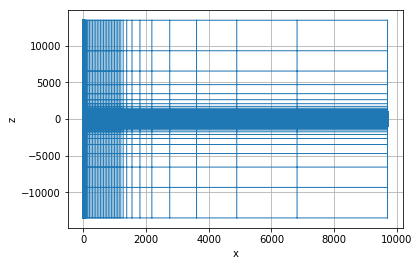

In [6]:
mesh.plotGrid()

# physical property model

Here, I discretize the model and assign a model value for the conductivity and permeability to every cell center in the mesh

In [7]:
sigma_x = sigma_background_horizontal * np.ones(mesh.nC)
sigma_z = sigma_background_vertical * np.ones(mesh.nC)

for s in [sigma_x, sigma_z]:
    s[model_parameters.ind_casing(mesh)] = sigma_casing
    s[model_parameters.ind_inside(mesh)] = sigma_inside
    
sigma = np.vstack([sigma_x, sigma_x, sigma_z]).T

In [8]:
mur = np.ones(mesh.nC)
mur[model_parameters.ind_casing(mesh)] = mur_casing

### plot the model

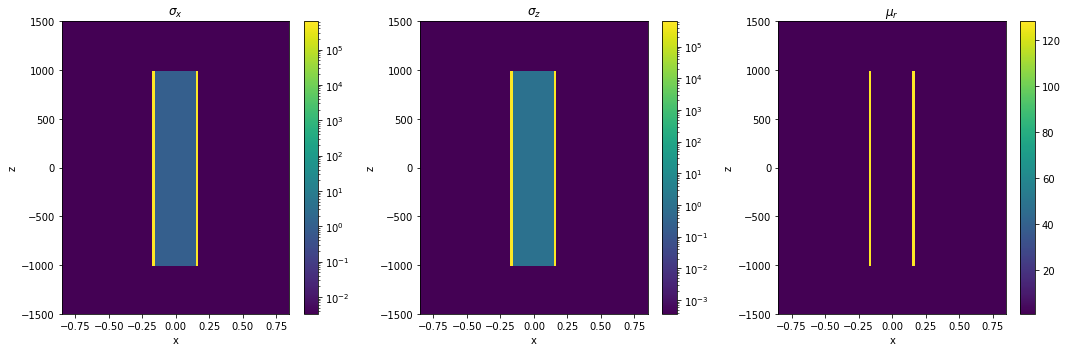

In [9]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
xlim = 5 * model_parameters.casing_b * np.r_[-1, 1]
zlim = 1.5 * model_parameters.casing_z

casingSim.view.plot_slice(mesh, sigma_x, ax=ax[0], pcolorOpts={"norm":LogNorm()})
ax[0].set_title("$\sigma_x$")

casingSim.view.plot_slice(mesh, sigma_z, ax=ax[1], pcolorOpts={"norm":LogNorm()})
ax[1].set_title("$\sigma_z$")

casingSim.view.plot_slice(mesh, mur, ax=ax[2])
ax[2].set_title("$\mu_r$")

for a in ax:
    a.set_xlim(xlim)
    a.set_ylim(zlim)

plt.tight_layout()


## Set up the source

This is a point current-dipole source

In [10]:
src_a = model_parameters.src_a
src_b = model_parameters.src_b

print(src_a, src_b)

[0. 0. 0.] [0. 0. 0.]


In [11]:
src = casingSim.sources.VerticalElectricDipole(
    modelParameters=model_parameters,
    meshGenerator=mesh_generator,
    physics="FDEM"
)

(-10, 10)

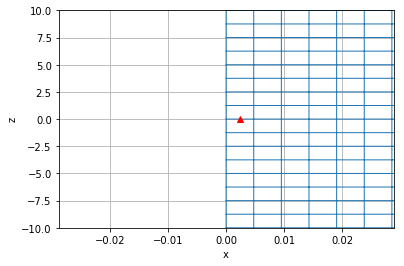

In [12]:
fig, ax = plt.subplots(1, 1)

xlim = model_parameters.casing_b * model_parameters.casing_b * np.r_[-1, 1]
zlim = 10 * np.r_[-1, 1]

mesh.plotGrid(ax=ax)
src.plot(ax=ax)

ax.set_xlim(xlim)
ax.set_ylim(zlim)

In [13]:
survey = FDEM.Survey(src.srcList)
prob = FDEM.Problem3D_j(mesh, mu=mu_0*mur, sigma=sigma)
prob.pair(survey)

## run the simulation

In [14]:
%time

fields = prob.fields(None)

CPU times: user 5 µs, sys: 1 µs, total: 6 µs
Wall time: 11 µs


## plot the fields

In [15]:
# I wrote a plotting widget that can take multiple models,
# this is just some wrangling to create the expected inputs
sim = casingSim.run.SimulationFDEM(
    meshGenerator=mesh_generator, 
    modelParameters=model_parameters, 
    src=src
)
simdict = {"model": sim}
fieldsdict = {"model": fields}

In [16]:
viewer = casingSim.view.FieldsViewer(
    model_keys=["model"], sim_dict=simdict, fields_dict=fieldsdict
)

In [17]:
viewer.widget_cross_section(
    defaults={
        "min_depth":-50, 
        "max_depth":50,
        "max_r":3*model_parameters.casing_b
    }
)

interactive(children=(FloatText(value=0.5095875, description='max_r'), FloatText(value=-50.0, description='min…

<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>(*args, **kwargs)>

## compute data

Here, I assume that you choose a single radius and plot over z, this can easily be interchanged.

In [18]:
rx_x = np.r_[0.5]
rx_z = np.linspace(-50., 50., 100)

rx_locs = discretize.utils.ndgrid([rx_x, np.r_[0], rx_z])

In [19]:
ex = fields[src.srcList[0], 'e'][:mesh.vnF[0]]
ez = fields[src.srcList[0], 'e'][mesh.vnF[:2].sum():]

by = fields[src.srcList[0], 'b']

In [20]:
def plot_data(x, y, ax=None, plot_type="plot", color="C0"):
    """
    Function for making nice plots. The plot_type can be "plot" for linear scale
    or "semilogy" for linear - log-scale. Negative values will plot with dashed lines
    """
    if ax is None:
        fig, ax = plt.subplots(1, 1)
        
    if plot_type == "plot":
        ax.plot(x, y, color=color)
        ax.ticklabel_format(axis="y", scilimits=(0, 0))
    elif plot_type == "semilogy":
        ax.semilogy(x, y, color=color)
        ax.semilogy(x, -y, color=color, linestyle="--")
    
    ax.grid(which="both", alpha=0.4)

    return ax

### radial electric field

- here, the solution is computed on radial cell faces, so I select the faces closest to the requested receiver locations 

In [21]:
rx_ex_inds = discretize.utils.closestPoints(mesh, rx_locs, gridLoc='Fx')

rx_ex_x = mesh.gridFx[rx_ex_inds[0], 0]
rx_ex_z = mesh.gridFx[rx_ex_inds, 2]

Text(0.5, 1.0, '$E_x$ imag, r=5.3e-01m')

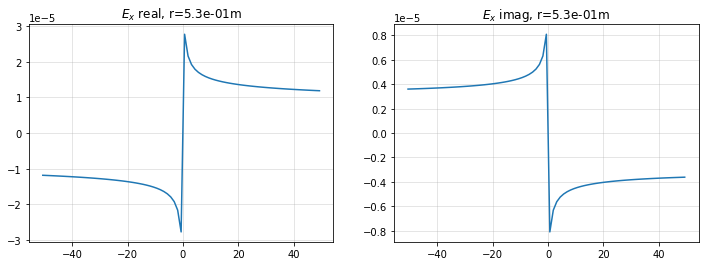

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

plot_data(rx_ex_z, ex[rx_ex_inds].real, ax=ax[0], plot_type="plot")
plot_data(rx_ex_z, ex[rx_ex_inds].imag, ax=ax[1], plot_type="plot")

ax[0].set_title("$E_x$ real, r={:1.1e}m".format(rx_ex_x))
ax[1].set_title("$E_x$ imag, r={:1.1e}m".format(rx_ex_x))


### vertical electric field
- here, the solution is on vertical cell faces, so I select the faces closest to the requested receiver locations 

In [23]:
rx_ez_inds = discretize.utils.closestPoints(mesh, rx_locs, gridLoc='Fz')

rx_ez_x = mesh.gridFz[rx_ez_inds[0], 0]
rx_ez_z = mesh.gridFz[rx_ez_inds, 2]

/anaconda3/lib/python3.6/site-packages/matplotlib/ticker.py:2241: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  "Data has no positive values, and therefore cannot be "


Text(0.5, 1.0, '$E_z$ imag, r=4.9e-01m')

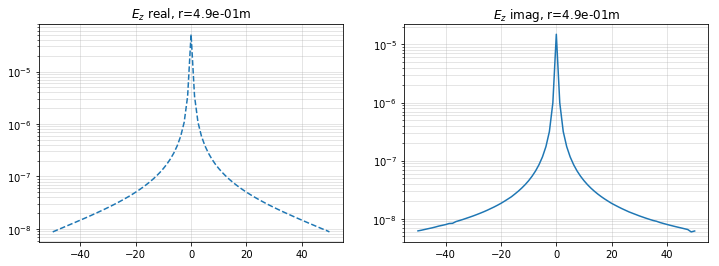

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

plot_data(rx_ez_z, ez[rx_ez_inds].real, ax=ax[0], plot_type="semilogy")
plot_data(rx_ez_z, ez[rx_ez_inds].imag, ax=ax[1], plot_type="semilogy")

ax[0].set_title("$E_z$ real, r={:1.1e}m".format(rx_ez_x))
ax[1].set_title("$E_z$ imag, r={:1.1e}m".format(rx_ez_x))


## azimuthal magnetic field
- here, the solution is on cell edges

In [25]:
rx_by_inds = discretize.utils.closestPoints(mesh, rx_locs, gridLoc='Ey')

rx_by_x = mesh.gridEy[rx_by_inds[0], 0]
rx_by_z = mesh.gridEy[rx_by_inds, 2]

Text(0.5, 1.0, '$B_{\\theta}$ imag, r=5.3e-01m')

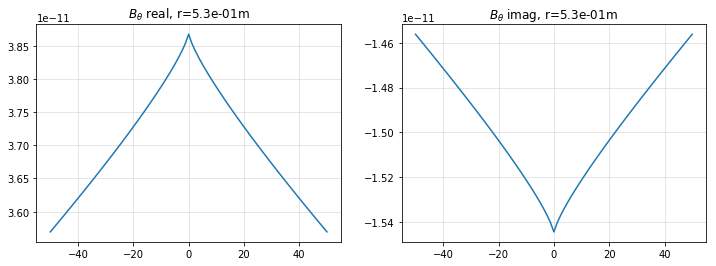

In [26]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

plot_data(rx_by_z, by[rx_by_inds].real, ax=ax[0], plot_type="plot")
plot_data(rx_by_z, by[rx_by_inds].imag, ax=ax[1], plot_type="plot")

ax[0].set_title("$B_{{\\theta}}$ real, r={:1.1e}m".format(rx_by_x))
ax[1].set_title("$B_{{\\theta}}$ imag, r={:1.1e}m".format(rx_by_x))

## Print version info

In [27]:
versions('HTML')